In [ ]:
! pip install mlflow==2.16.0

In [ ]:
! pip install pycaret[full]

In [ ]:
! pip install pandas numpy==1.26.4

# Dependencies

In [23]:
import pycaret.regression as pcr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open('202001-citibike-tripdata_1.csv', 'r') as file:
    df_base = pd.read_csv(file, parse_dates=['started_at', 'ended_at'])

# Data Prep

In [4]:
# PADRONIZING START_STATION_ID DATA TYPE (VERY IMPORTANT FOR PANDAS)
df_base['start_station_id'] = df_base['start_station_id'].astype(str).str.strip()

In [5]:
# EXTRACTING TIME-BASED FEATURES
df_base['day'] = df_base['started_at'].dt.day
df_base['hour'] = df_base['started_at'].dt.hour
df_base['weekday'] = df_base['started_at'].dt.dayofweek
df_base['trip_duration'] = (df_base['ended_at'] - df_base['started_at']).dt.total_seconds()

In [ ]:
# AGGREGATING BY DAY-HOUR FOR EACH STATION
df_agg = df_base.groupby(['start_station_id','day','hour', 'weekday']).agg(
    trip_amount=('ride_id', 'count'),  # Count of 'ride_id'
    avg_trip_duration=('trip_duration', 'mean'),  # Average of 'trip_duration'
  ).reset_index()

# Training

In [7]:
# PYCARET SETUP
catboost_setup = pcr.setup(
    # basic config
    data=df_agg,
    target='trip_amount',
    categorical_features=['start_station_id', 'weekday'],
    numeric_features=['avg_trip_duration', 'day', 'hour'],
    # for reproducibility
    verbose=True,
    session_id=321,
    # experimental
    #preprocess=True,
    #transform_target=True,
    #normalize=True,
    #remove_outliers=True,
)

,Description,Value
0,Session id,321
1,Target,trip_amount
2,Target type,Regression
3,Original data shape,"(294183, 6)"
4,Transformed data shape,"(294183, 12)"
5,Transformed train set shape,"(205928, 12)"
6,Transformed test set shape,"(88255, 12)"
7,Numeric features,3
8,Categorical features,2
9,Preprocess,True


In [ ]:
# TEST-TRAINING MODELS FOR COMPARISON WITH CATBOOST
models_comparison = pcr.compare_models()

In [8]:
# TRAINING THE MODEL
catboost_model = pcr.create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4342,5.7496,2.3978,0.6647,0.3908,0.5602
1,1.4176,5.5869,2.3637,0.6729,0.3881,0.5596
2,1.4575,5.8163,2.4117,0.6492,0.3956,0.5742
3,1.4460,5.7636,2.4007,0.6404,0.3916,0.5673
4,1.4165,5.5056,2.3464,0.6500,0.3928,0.5658
5,1.4185,5.2666,2.2949,0.6452,0.3922,0.5607
6,1.4385,5.5547,2.3568,0.6393,0.3962,0.5755
7,1.4323,5.7550,2.3990,0.6640,0.3914,0.5631
8,1.4356,5.5413,2.3540,0.6410,0.3946,0.5683


In [9]:
# TUNING THE MODEL
tuned_catboost = pcr.tune_model(catboost_model, n_iter=10, search_library='optuna', search_algorithm='tpe')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9729,11.7278,3.4246,0.3160,0.5048,0.8822
1,1.9560,11.6690,3.4160,0.3167,0.5051,0.8878
2,1.9651,11.3538,3.3695,0.3153,0.5069,0.8919
3,1.9577,10.8148,3.2886,0.3252,0.5061,0.8890
4,1.9349,10.6876,3.2692,0.3206,0.5042,0.8894
5,1.9220,9.9892,3.1606,0.3271,0.5025,0.8830
6,1.9478,10.4898,3.2388,0.3188,0.5084,0.9001
7,1.9659,11.8247,3.4387,0.3096,0.5068,0.8850
8,1.9228,10.4912,3.2390,0.3204,0.5031,0.8860


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
pcr.evaluate_model(catboost_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [11]:
prediction = pcr.predict_model(catboost_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.4272,5.5173,2.3489,0.6497,0.3912,0.5648


In [12]:
prediction['error'] = prediction['trip_amount'] - prediction['prediction_label']

In [13]:
prediction['abs_error'] = prediction['error'].abs()

# Exploration

In [31]:
def normalize(data_list):
    """Normalizes a list of numbers to the range [0, 1]."""
    arr = np.array(data_list, dtype=float) # Ensure float for division
    if arr.min() == arr.max(): # Handle case where all elements are the same
        return np.zeros_like(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

## Daily Trips

In [28]:
daily_trips = prediction.groupby(['day']).agg(
    tpd=('trip_amount', 'count'),
  ).reset_index()
daily_trips['normalized'] = normalize(daily_trips['tpd'])

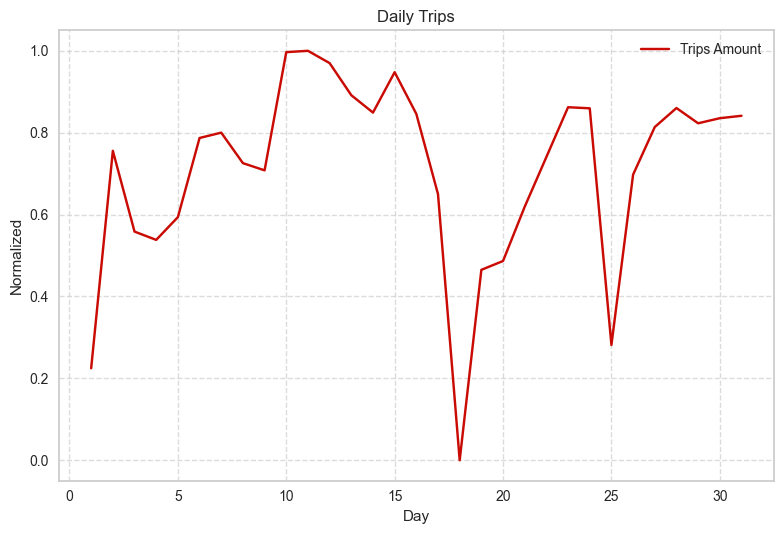

In [30]:
fig, ax = plt.subplots()
ax.plot(
    daily_trips['day'],
    daily_trips['normalized'],
    marker='x',
    linestyle='-',
    color='r',
    label='Trips Amount'
)

ax.set_xlabel('Day')
ax.set_ylabel('Normalized')
ax.set_title('Daily Trips')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Peak Analysis

In [34]:
p1 = prediction[['weekday', 'day', 'hour', 'trip_amount', 'abs_error']]
p1['is_workday'] = p1['weekday'] >= 5

In [44]:
workday_trips = p1[p1['is_workday'] == False].groupby(['hour']).agg(
    tph=('trip_amount', 'count'),
    mae=('abs_error', 'mean')
  ).reset_index()

weekend_trips = p1[p1['is_workday'] == True].groupby(['hour']).agg(
    tph=('trip_amount', 'count'),
    mae=('abs_error', 'mean')
  ).reset_index()

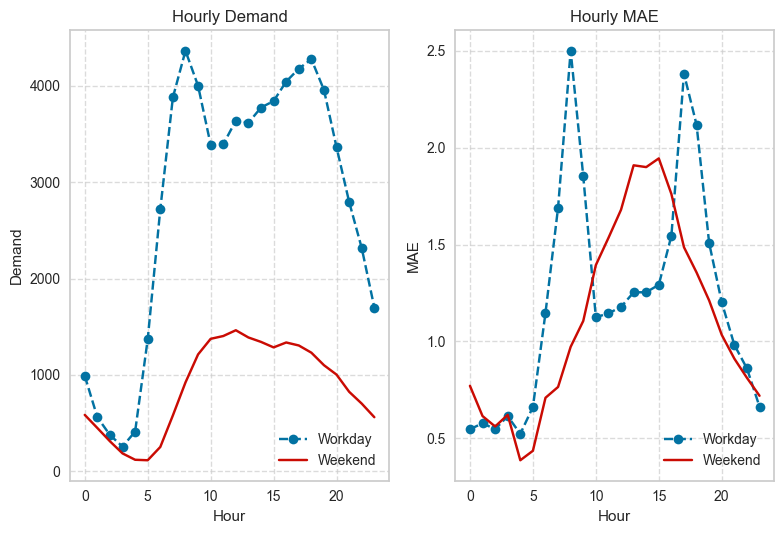

In [45]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(
    workday_trips['hour'],
    workday_trips['tph'],
    marker='o',
    linestyle='--',
    color='b',
    label='Workday'
)

ax[0].plot(
    weekend_trips['hour'],
    weekend_trips['tph'],
    marker='x',
    linestyle='-',
    color='r',
    label='Weekend'
)

ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Demand')
ax[0].set_title('Hourly Demand')
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(
    workday_trips['hour'],
    workday_trips['mae'],
    marker='o',
    linestyle='--',
    color='b',
    label='Workday'
)

ax[1].plot(
    weekend_trips['hour'],
    weekend_trips['mae'],
    marker='x',
    linestyle='-',
    color='r',
    label='Weekend'
)

ax[1].set_xlabel('Hour')
ax[1].set_ylabel('MAE')
ax[1].set_title('Hourly MAE')
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Error and Demand

In [ ]:
error_by_hour = prediction.groupby(['hour']).agg(
    avg_abs_error=('abs_error', 'mean'),
  ).reset_index()
error_by_hour['normalized'] = normalize(error_by_hour['avg_abs_error'])

trips_per_hour = prediction.groupby(['hour']).agg(
    tph=('trip_amount', 'count'),
  ).reset_index()
trips_per_hour['normalized'] = normalize(trips_per_hour['tph'])

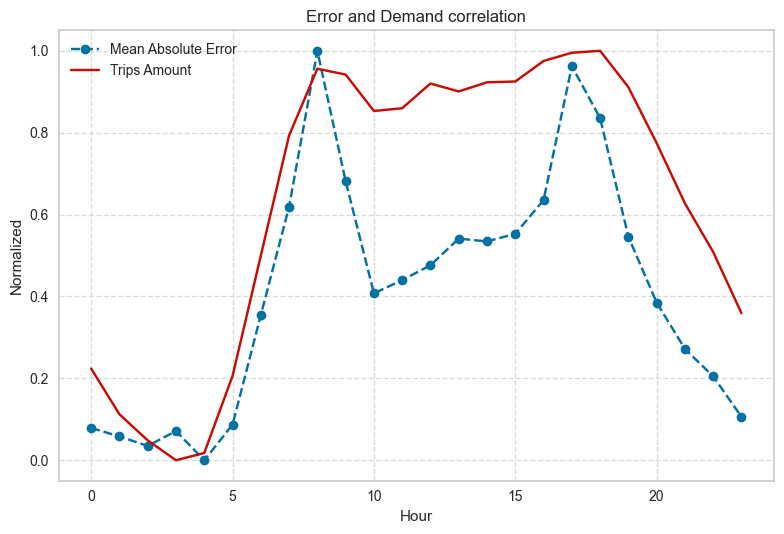

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    error_by_hour['hour'],
    error_by_hour['normalized'],
    marker='o',
    linestyle='--',
    color='b',
    label='Mean Absolute Error'
)

ax.plot(
    trips_per_hour['hour'],
    trips_per_hour['normalized'],
    marker='x',
    linestyle='-',
    color='r',
    label='Trips Amount'
)

ax.set_xlabel('Hour')
ax.set_ylabel('Normalized')
ax.set_title('Overall Error and Demand')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Peak Demand Stations

In [ ]:
popularity_rank = prediction[prediction['hour'] == 8.0].groupby(['start_station_id']).agg(
    avg_abs_error=('abs_error', 'mean'),
  ).reset_index()

In [ ]:
top25ids = 
top25ids